In [17]:
from astropy.io import ascii
from astropy.table import Table

import numpy as np
import h5py

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.mplot3d import Axes3D

from scipy import spatial
from scipy.ndimage import label
from scipy.ndimage.filters import uniform_filter, gaussian_filter

from scipy import stats


import illustris_python as il
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy import units as u

import tqdm

import pickle

In [18]:
basePath = './sims.TNG/TNG300-1/output/'

In [19]:
snaps_full = np.array([99, 91, 84, 78, 72, 67, 59, 50, 40, 33])
zs_full = np.array([0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.70, 1.00, 1.50, 2.00])
scale_factors = 1 / (1 + zs_full)
h = 0.704

In [20]:
def cal_fof(start, cands):
    
    check = np.full(len(cands), True, dtype = bool)
    
    f1mask = np.sqrt(np.sum((cands - start)**2, axis = 1)) <= 4
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        return []
    
    new_index = []
    
    temp_index = []
    
    first = True
    
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
        for j in range(len(cand_index)):
            f2mask = np.sqrt(np.sum((cands - cands[cand_index[j]])**2, axis = 1)) <= 4
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index) == 0:
                continue
            
            temp_index.extend(list(f2_index))
            
        new_index.extend(temp_index)
        
        if len(temp_index) ==0:
            break
    
    f1_index.extend(new_index)
    final_index = f1_index
    
    return final_index

In [21]:
SFRs = h5py.File('star_formation_rates.hdf5', 'r')

## QF in stellar mass bins

In [ ]:
for isnap, snap in enumerate(snaps_full[:-3]):
# for isnap, snap in enumerate(snaps_full[:1]):

    # isnap = np.where(snaps_full == snap)[0]

    print(snap)
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
#         gal_mask = MassInRad >= 10**8.5

    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')

    with open(f'./lists_all/m200_snap{snap:03d}', "rb") as f:
        m200s = pickle.load(f)

    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
        mem_ids_twice = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)

    m200s = np.array(m200s)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)

    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)

    num_mems_twice = [len(x) for x in mem_ids_twice]
    num_mems_twice = np.array(num_mems_twice)

    isomask = fofs <= 0.06
    conmask = fofs > 0.06

#     mem_ids = np.array(mem_ids, dtype = object)
#     mem_ids_twice = np.array(mem_ids_twice, dtype = object)
    mem_ids = np.array(mem_ids_twice, dtype = object)


    # calcualte
    fq_iso_med = []
    fq_iso_std = []
    
    fq_con_med = []
    fq_con_std = []

    sm_range = np.arange(8.5, 11.5, 0.5)

    for sm in sm_range:
        
        sm_id = np.where( (MassInRad >= 10**sm) & (MassInRad <= 10**(sm + 0.5)) )[0]
        
        fq_iso_med_hm = []
        fq_iso_std_hm = []
        
        fq_con_med_hm = []
        fq_con_std_hm = []
        
        for hm in np.arange(13, 14.5, 0.5):
            
            hmmask = (m200s >= 10**hm) & (m200s <= 10**(hm + 0.5))     
                        
            ############ iso
            if np.any(hmmask & isomask):
                iso_id = np.concatenate(mem_ids[hmmask & isomask])
            
                mem_iso_mask = np.isin(sm_id, iso_id)
                isos = sm_id[mem_iso_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in isos]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]

                fq_meds = []
                
                for _ in range(100):
                    boot = np.random.choice(len(isos), size = len(isos), replace = True)
                    
                    ssfrs =  sfrs[boot] / (MassInRad[:][isos[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)

                fq_iso_med_hm.append(np.mean(fq_meds))
                fq_iso_std_hm.append(np.std(fq_meds))

            else:
                fq_iso_med_hm.append(np.nan)
                fq_iso_std_hm.append(np.nan)

            ############ con
            if np.any(hmmask & conmask):
                con_id = np.concatenate(mem_ids[hmmask & conmask])

                mem_con_mask = np.isin(sm_id, con_id)
                cons = sm_id[mem_con_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in cons]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]
                
                fq_meds = []

                for _ in range(100):
                    
                    boot = np.random.choice(len(cons), size = len(cons), replace = True)
                    
                    ssfrs = sfrs[boot] / (MassInRad[:][cons[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)
                    
                fq_con_med_hm.append(np.mean(fq_meds))
                fq_con_std_hm.append(np.std(fq_meds))

            else:
                fq_con_med_hm.append(np.nan)
                fq_con_std_hm.append(np.nan)
        
        fq_iso_med.append(fq_iso_med_hm)
        fq_iso_std.append(fq_iso_std_hm)
        fq_con_med.append(fq_con_med_hm)
        fq_con_std.append(fq_con_std_hm)
    
    fq_iso_med = np.array(fq_iso_med)
    fq_iso_std = np.array(fq_iso_std)
    fq_con_med = np.array(fq_con_med)
    fq_con_std = np.array(fq_con_std)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.subplots_adjust(wspace = 0)
    
    ##
    
    for a in range(3): 
        ax[a].scatter(sm_range, fq_con_med[:, a], label = 'connected', marker = '^', edgecolor = 'royalblue', facecolor = 'none', s = 200)
        ax[a].errorbar(sm_range, fq_con_med[:, a], yerr = fq_con_std[:, a], linestyle = '', color = 'royalblue')

        ax[a].scatter(sm_range, fq_iso_med[:, a], label = 'isolated', marker = '*', edgecolor = 'firebrick', facecolor = 'none', s = 200)
        ax[a].errorbar(sm_range, fq_iso_med[:, a], yerr = fq_iso_std[:, a], linestyle = '')

        ax[a].legend(fontsize = 13)

        ax[a].set_xlabel('stellar mass', fontsize = 15)
        
        if a == 0:
            ax[a].set_ylabel(r'$F_{Quies.}$', fontsize = 15)
        else:
            pass
        
        ax[a].set_ylim(0.0, 1.05)
        
#         ax[im].xaxis.set_major_locator(MultipleLocator(0.02))
        ax[a].yaxis.set_major_locator(MultipleLocator(0.2))

        ax[a].xaxis.set_minor_locator(AutoMinorLocator())
        ax[a].yaxis.set_minor_locator(AutoMinorLocator())

        ax[a].tick_params(which = 'major', length = 10, direction = 'in', labelsize = 13)
        ax[a].tick_params(which = 'minor', length = 5, direction = 'in', labelsize = 13)

        ax[a].xaxis.set_ticks_position('both')
        ax[a].yaxis.set_ticks_position('both')
        
#     fig.tight_layout()
    fig.suptitle(f'z = {z:.1f}')
    
    fig.savefig('./figs/stellarmass_{z:.1f}.png')

99
91


99
91
84
78
72
67
59


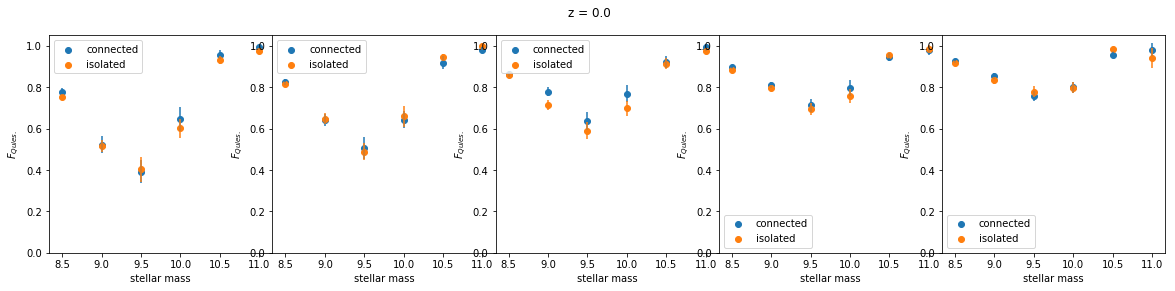

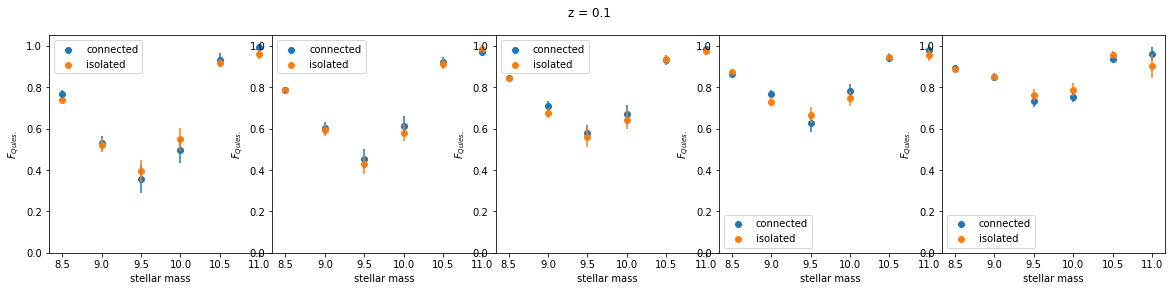

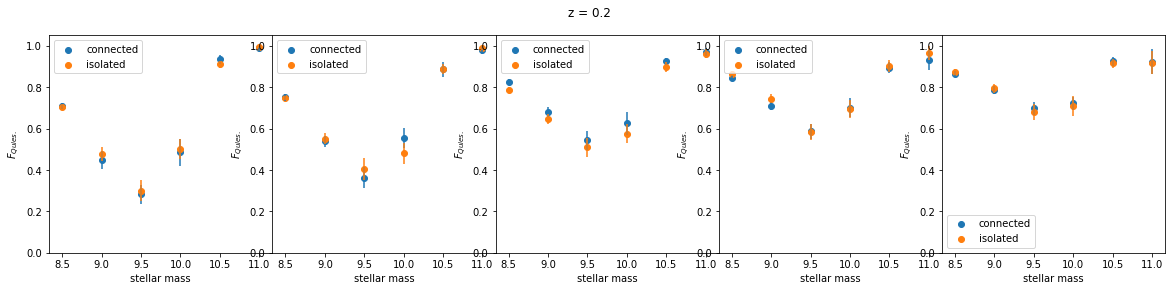

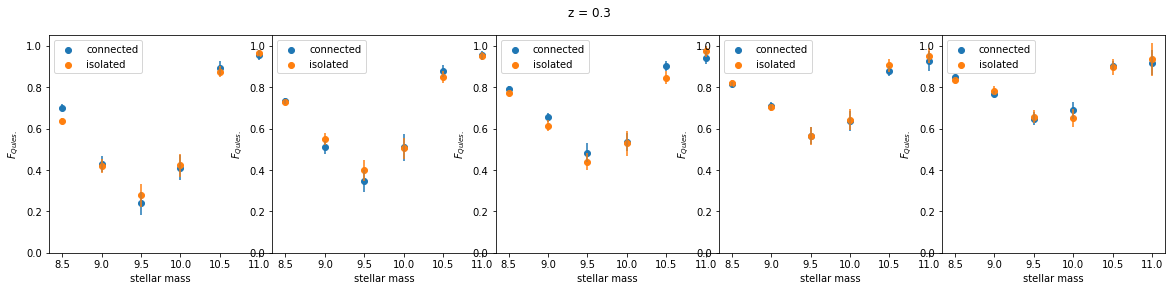

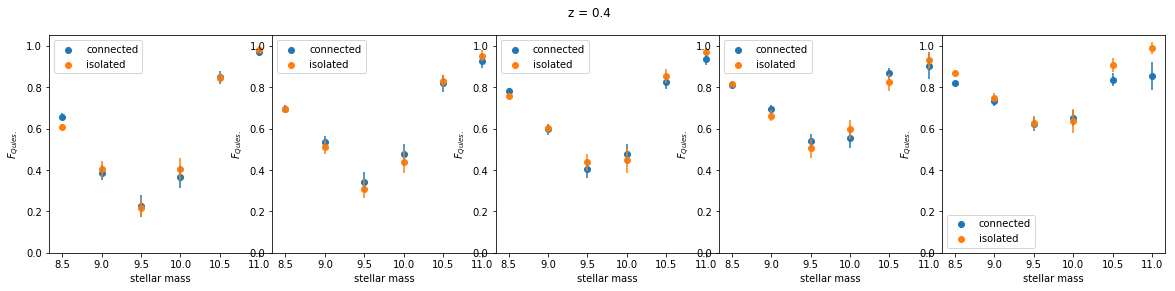

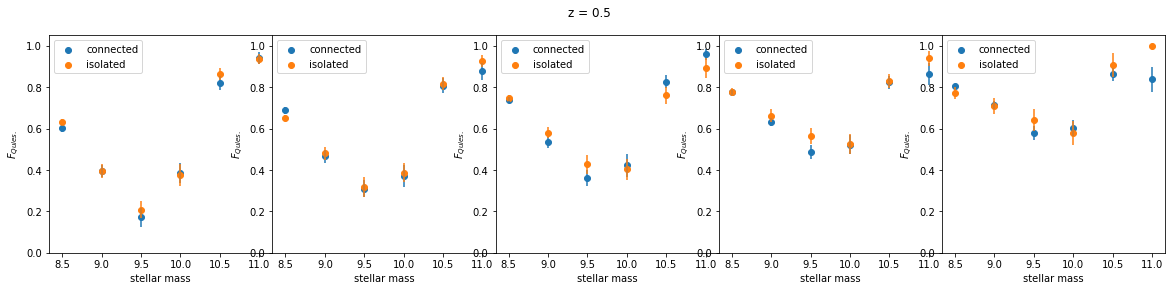

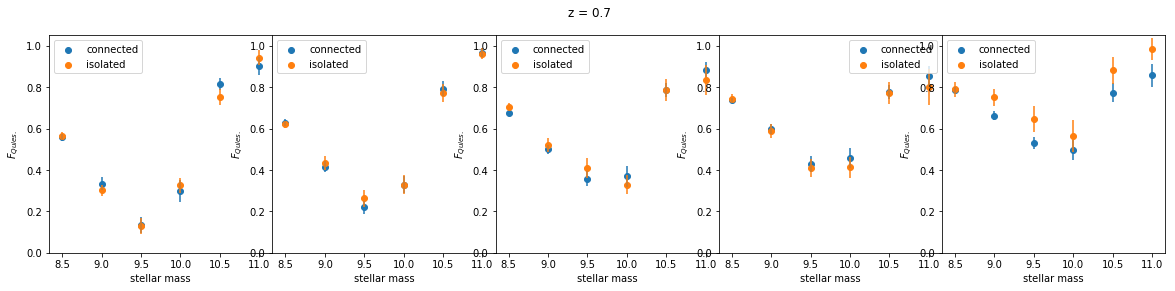

In [16]:
for isnap, snap in enumerate(snaps_full[:-3]):
# for isnap, snap in enumerate(snaps_full[:1]):

    # isnap = np.where(snaps_full == snap)[0]

    print(snap)
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
#         gal_mask = MassInRad >= 10**8.5

    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')

    with open(f'./lists_all/m200_snap{snap:03d}', "rb") as f:
        m200s = pickle.load(f)

    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
        mem_ids_twice = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)

    m200s = np.array(m200s)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)

    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)

    num_mems_twice = [len(x) for x in mem_ids_twice]
    num_mems_twice = np.array(num_mems_twice)

    isomask = fofs <= 0.06
    conmask = fofs > 0.06
    
    cpars_mask = cpars <= 6
    
#     mem_ids = np.array(mem_ids, dtype = object)
#     mem_ids_twice = np.array(mem_ids_twice, dtype = object)
    mem_ids = np.array(mem_ids_twice, dtype = object)


    # calcualte
    fq_iso_med = []
    fq_iso_std = []
    
    fq_con_med = []
    fq_con_std = []

    sm_range = np.arange(8.5, 11.5, 0.5)

    for sm in sm_range:
        
        sm_id = np.where( (MassInRad >= 10**sm) & (MassInRad <= 10**(sm + 0.5)) )[0]
        
        fq_iso_med_hm = []
        fq_iso_std_hm = []
        
        fq_con_med_hm = []
        fq_con_std_hm = []
        
        for hm in np.arange(13, 14.5, 0.5):
            
            hmmask = (m200s >= 10**hm) & (m200s <= 10**(hm + 0.5))     
                        
            ############ iso
            mask = cpars_mask & hmmask & isomask 
            if np.any(mask):
                iso_id = np.concatenate(mem_ids[mask])
            
                mem_iso_mask = np.isin(sm_id, iso_id)
                isos = sm_id[mem_iso_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in isos]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]

                fq_meds = []
                
                for _ in range(100):
                    boot = np.random.choice(len(isos), size = len(isos), replace = True)
                    
                    ssfrs =  sfrs[boot] / (MassInRad[:][isos[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)

                fq_iso_med_hm.append(np.mean(fq_meds))
                fq_iso_std_hm.append(np.std(fq_meds))

            else:
                fq_iso_med_hm.append(np.nan)
                fq_iso_std_hm.append(np.nan)

            ############ con
            mask = cpars_mask & hmmask & conmask 
            if np.any(mask):
                con_id = np.concatenate(mem_ids[mask])

                mem_con_mask = np.isin(sm_id, con_id)
                cons = sm_id[mem_con_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in cons]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]
                
                fq_meds = []

                for _ in range(100):
                    
                    boot = np.random.choice(len(cons), size = len(cons), replace = True)
                    
                    ssfrs = sfrs[boot] / (MassInRad[:][cons[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)
                    
                fq_con_med_hm.append(np.mean(fq_meds))
                fq_con_std_hm.append(np.std(fq_meds))

            else:
                fq_con_med_hm.append(np.nan)
                fq_con_std_hm.append(np.nan)
        
        fq_iso_med.append(fq_iso_med_hm)
        fq_iso_std.append(fq_iso_std_hm)
        fq_con_med.append(fq_con_med_hm)
        fq_con_std.append(fq_con_std_hm)
    
    fq_iso_med = np.array(fq_iso_med)
    fq_iso_std = np.array(fq_iso_std)
    fq_con_med = np.array(fq_con_med)
    fq_con_std = np.array(fq_con_std)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.subplots_adjust(wspace = 0)
    
    ##
    
    for a in range(3): 
        ax[a].scatter(sm_range, fq_con_med[:, a], label = 'connected')
        ax[a].errorbar(sm_range, fq_con_med[:, a], yerr = fq_con_std[:, a], linestyle = '')

        ax[a].scatter(sm_range, fq_iso_med[:, a], label = 'isolated')
        ax[a].errorbar(sm_range, fq_iso_med[:, a], yerr = fq_iso_std[:, a], linestyle = '')

        ax[a].legend()

        ax[a].set_xlabel('stellar mass')
        ax[a].set_ylabel(r'$F_{Quies.}$')

        ax[a].set_ylim(0.0, 1.05)

#     fig.tight_layout()
    fig.suptitle(f'z = {z:.1f}')

99
91
84
78
72
67
59


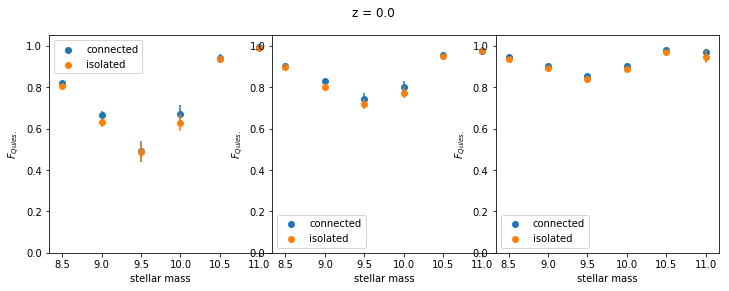

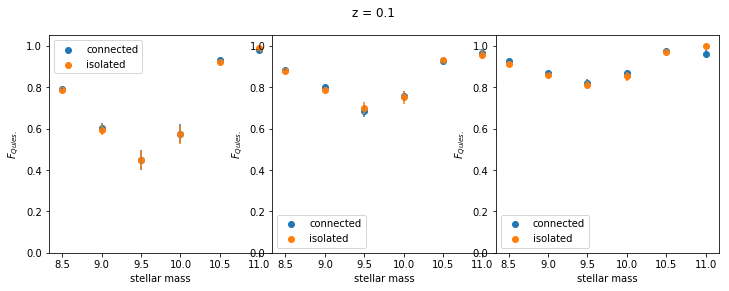

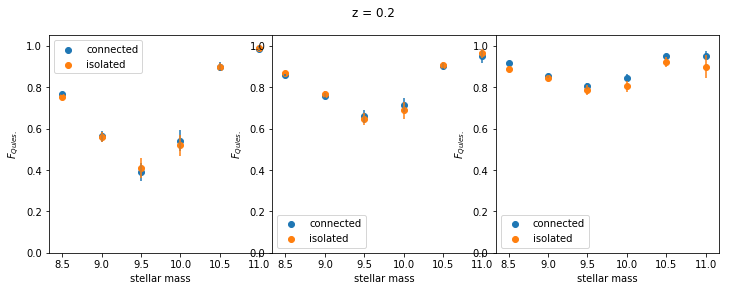

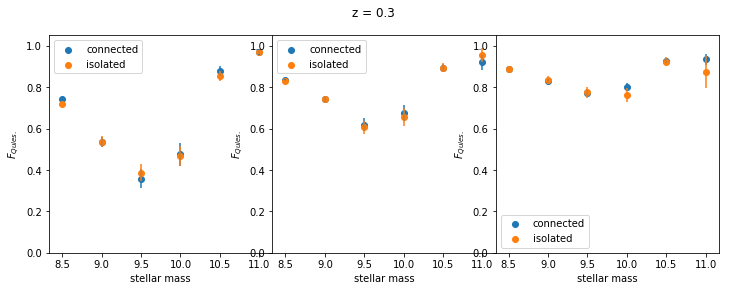

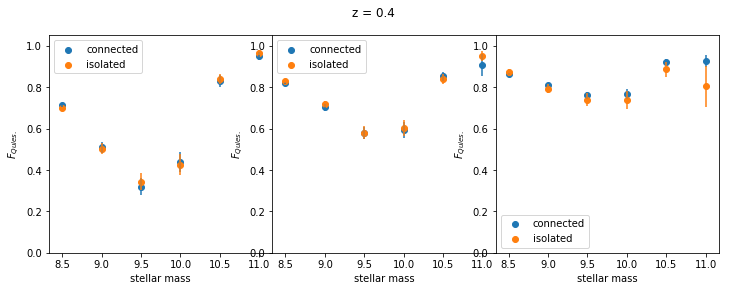

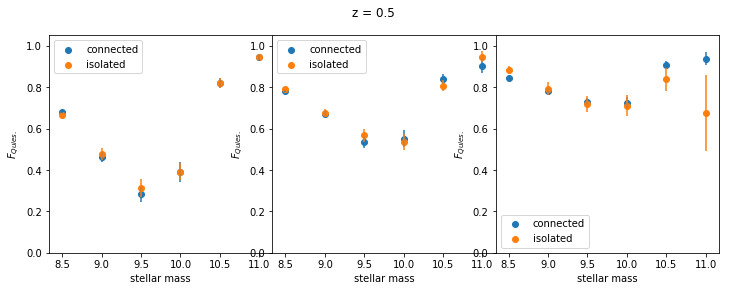

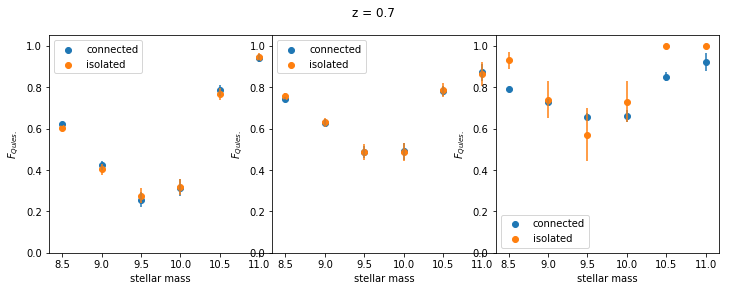

In [9]:
for isnap, snap in enumerate(snaps_full[:-3]):
# for isnap, snap in enumerate(snaps_full[:1]):

    # isnap = np.where(snaps_full == snap)[0]

    print(snap)
    
    scale_factor = scale_factors[isnap]
    z = zs_full[isnap]

    with h5py.File(f'./groups/grp_snap{snap}.hdf5', 'r') as f:
        #binning the grps in halo mass
        grp_m200 = f['Group_M_Crit200'][:] * 1e10 / 0.704
        grp_r200 = f['Group_R_Crit200'][:]
        grp_pos = f['GroupPos'][:]

    with h5py.File(f'./subhalos/subs_{snap}.hdf5', 'r') as f:
        MassInRad = f['SubhaloMassInRadType'][:, 4] * 1e10 / 0.704
        SubhaloGrNr = f['SubhaloGrNr'][:]
        SubhaloPos = f['SubhaloPos'][:]
#         gal_mask = MassInRad >= 10**8.5

    halos = h5py.File(f'halo_structure_{snap:03d}.hdf5')

    with open(f'./lists_all/m200_snap{snap:03d}', "rb") as f:
        m200s = pickle.load(f)

    with open(f'./lists_all/mem_ids_snap{snap:03d}', "rb") as f:
        mem_ids = pickle.load(f)

    with open(f'./lists_all/mem_ids_twice_snap{snap:03d}', "rb") as f:
        mem_ids_twice = pickle.load(f)

    with open(f'./lists_all/fofs_snap{snap:03d}', "rb") as f:
        fofs = pickle.load(f)

    with open(f'./lists_all/fqs_snap{snap:03d}', "rb") as f:
        fqs = pickle.load(f)

    with open(f'./lists_all/fqs_twice_snap{snap:03d}', "rb") as f:
        fqs_twice = pickle.load(f)

    with open(f'./lists_all/cpars_snap{snap:03d}', "rb") as f:
        cpars = pickle.load(f)

    m200s = np.array(m200s)
    fofs = np.array(fofs)
    fqs = np.array(fqs)
    fqs_twice = np.array(fqs_twice)
    cpars = np.array(cpars)

    num_mems = [len(x) for x in mem_ids]
    num_mems = np.array(num_mems)

    num_mems_twice = [len(x) for x in mem_ids_twice]
    num_mems_twice = np.array(num_mems_twice)

    isomask = fofs <= 0.06
    conmask = fofs > 0.06

#     mem_ids = np.array(mem_ids, dtype = object)
#     mem_ids_twice = np.array(mem_ids_twice, dtype = object)
    mem_ids = np.array(mem_ids_twice, dtype = object)


    # calcualte
    fq_iso_med = []
    fq_iso_std = []
    
    fq_con_med = []
    fq_con_std = []

    sm_range = np.arange(8.5, 11.5, 0.5)

    for sm in sm_range:
        
        sm_id = np.where( (MassInRad >= 10**sm) & (MassInRad <= 10**(sm + 0.5)) )[0]
        
        fq_iso_med_hm = []
        fq_iso_std_hm = []
        
        fq_con_med_hm = []
        fq_con_std_hm = []
        
        for hm in np.arange(13, 15, 0.5):
            
            hmmask = (m200s >= 10**hm) & (m200s <= 10**(hm + 0.5))     
                        
            ############ iso
            if np.any(hmmask & isomask):
                iso_id = np.concatenate(mem_ids[hmmask & isomask])
            
                mem_iso_mask = np.isin(sm_id, iso_id)
                isos = sm_id[mem_iso_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in isos]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]

                fq_meds = []
                
                for _ in range(100):
                    boot = np.random.choice(len(isos), size = len(isos), replace = True)
                    
                    ssfrs =  sfrs[boot] / (MassInRad[:][isos[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)

                fq_iso_med_hm.append(np.mean(fq_meds))
                fq_iso_std_hm.append(np.std(fq_meds))

            else:
                fq_iso_med_hm.append(np.nan)
                fq_iso_std_hm.append(np.nan)

            ############ con
            if np.any(hmmask & conmask):
                con_id = np.concatenate(mem_ids[hmmask & conmask])

                mem_con_mask = np.isin(sm_id, con_id)
                cons = sm_id[mem_con_mask]
                
                sfr_idx = [np.where(SFRs[f'Snapshot_{snap}']['SubfindID'][:] == x)[0] for x in cons]
                sfr_idx = np.array(sfr_idx)
                sfrs = SFRs[f'Snapshot_{snap}']['SFR_MsunPerYrs_in_InRad_200Myrs'][:][sfr_idx]
                
                fq_meds = []

                for _ in range(100):
                    
                    boot = np.random.choice(len(cons), size = len(cons), replace = True)
                    
                    ssfrs = sfrs[boot] / (MassInRad[:][cons[boot]])
                    quies_mask = ssfrs <= 1 / 3 / cosmo.age(z).to(u.yr).value
                    
                    fq = sum(quies_mask) / len(quies_mask)
                    fq_meds.append(fq)
                    
                fq_con_med_hm.append(np.mean(fq_meds))
                fq_con_std_hm.append(np.std(fq_meds))

            else:
                fq_con_med_hm.append(np.nan)
                fq_con_std_hm.append(np.nan)
        
        fq_iso_med.append(fq_iso_med_hm)
        fq_iso_std.append(fq_iso_std_hm)
        fq_con_med.append(fq_con_med_hm)
        fq_con_std.append(fq_con_std_hm)
    
    fq_iso_med = np.array(fq_iso_med)
    fq_iso_std = np.array(fq_iso_std)
    fq_con_med = np.array(fq_con_med)
    fq_con_std = np.array(fq_con_std)
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    fig.subplots_adjust(wspace = 0)
    
    ##
    
    for a in range(3): 
        ax[a].scatter(sm_range, fq_con_med[:, a], label = 'connected')
        ax[a].errorbar(sm_range, fq_con_med[:, a], yerr = fq_con_std[:, a], linestyle = '')

        ax[a].scatter(sm_range, fq_iso_med[:, a], label = 'isolated')
        ax[a].errorbar(sm_range, fq_iso_med[:, a], yerr = fq_iso_std[:, a], linestyle = '')

        ax[a].legend()

        ax[a].set_xlabel('stellar mass')
        ax[a].set_ylabel(r'$F_{Quies.}$')

        ax[a].set_ylim(0.0, 1.05)

#     fig.tight_layout()
    fig.suptitle(f'z = {z:.1f}')

(array([16493347.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,  1411797.,   238884.]),
 array([-20.        , -16.79623455, -13.5924691 , -10.38870365,
         -7.1849382 ,  -3.98117274,  -0.77740729,   2.42635816,
          5.63012361,   8.83388906,  12.03765451]),
 <a list of 10 Patch objects>)

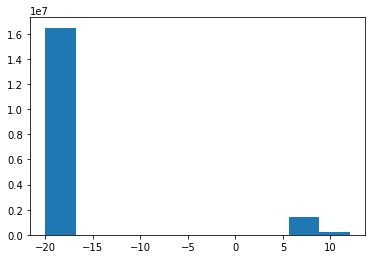

In [28]:
plt.hist(np.log10(MassInRad +1e-20))

## per concentration, member (within r200 or 2 * r200)